<a href="https://colab.research.google.com/github/Chirag314/Tabular-Data-Series/blob/main/TPMay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######Reference  https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense

https://colab.research.google.com/drive/1d8ckS5wJkZzrLmtrrcMK284d5wczcVd8#scrollTo=2HgSxukmyeY3


In [33]:
# Tabular play ground series May.
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMClassifier
import warnings, gc, string, random
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff


In [34]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download tabular-playground-series-may-202 -f train.csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
404 - Not Found


In [35]:
# Train data
train = pd.read_csv('/train.csv', sep=',', index_col='id')
train1=train.copy()       #Copy training data in case we need original data later.
train.shape

(900000, 32)

In [36]:
# Test data
test = pd.read_csv('/test.csv',sep=',',index_col='id')
test.head()

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
id                                                                             
900000  0.442517  0.174380 -0.999816  0.762741  0.186778 -1.074775  0.501888   
900001 -0.605598 -0.305715  0.627667 -0.578898 -1.750931  1.355550 -0.190911   
900002  0.303990  2.445110  0.246515  0.818248  0.359731 -1.331845  1.358622   
900003  0.154053  0.260126 -1.367092 -0.093175 -1.111034 -0.948481  1.119220   
900004 -1.651904 -0.424266 -0.667356 -0.322124 -0.089462  0.181705  1.784983   

        f_07  f_08  f_09  ...      f_21      f_22      f_23      f_24  \
id                        ...                                           
900000     6     6     0  ... -1.006400 -1.193879 -2.435736 -2.427430   
900001     1     3     4  ...  2.382405  0.149442  1.883322 -2.848714   
900002     3     3     4  ... -7.026098  1.312277 -5.157192  1.714005   
900003     0     0     4  ... -0.594532 -3.939475  1.754570 -2.364007   
900004     2     2     2  ...  0.084906 -0.985736 -0.130467 -3.557893   

            f_25      f_26        f_27        f_28  f_29  f_30  
id                                                              
900000 -1.966887  5.734205  BAAABADLAC   99.478419     0     0  
900001 -0.725155  3.194219  AFABBAEGCB  -65.993825     1     0  
900002  0.585032  0.066898  BBACABBKEE  -87.405622     0     1  
900003 -1.003320  3.893099  AEBEAACQCC -281.293460     0     0  
900004  1.210687  1.861884  AEBBBBDABF   25.629415     0     2  

[5 rows x 31 columns]

In [80]:
#submission data
sub=pd.read_csv('/sample_submission.csv')

In [37]:
# Check data
train.info()
# It seems all except f_27 are float type . F_27 is object string type. Also there are no missing values in any columns.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float64
 1   f_01    900000 non-null  float64
 2   f_02    900000 non-null  float64
 3   f_03    900000 non-null  float64
 4   f_04    900000 non-null  float64
 5   f_05    900000 non-null  float64
 6   f_06    900000 non-null  float64
 7   f_07    900000 non-null  int64  
 8   f_08    900000 non-null  int64  
 9   f_09    900000 non-null  int64  
 10  f_10    900000 non-null  int64  
 11  f_11    900000 non-null  int64  
 12  f_12    900000 non-null  int64  
 13  f_13    900000 non-null  int64  
 14  f_14    900000 non-null  int64  
 15  f_15    900000 non-null  int64  
 16  f_16    900000 non-null  int64  
 17  f_17    900000 non-null  int64  
 18  f_18    900000 non-null  int64  
 19  f_19    900000 non-null  float64
 20  f_20    900000 non-null  float64
 21  f_21    90

f_00           f_01           f_02           f_03  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -0.000286       0.001165       0.001174      -0.001368   
std         0.998888       0.999193       1.000514       1.000175   
min        -4.599856      -4.682199      -4.642676      -4.658816   
25%        -0.675490      -0.675162      -0.674369      -0.676114   
50%         0.001144       0.002014       0.002218      -0.002227   
75%         0.674337       0.675021       0.677505       0.672544   
max         4.749301       4.815699       4.961982       4.454920   

                f_04           f_05           f_06           f_07  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -0.000571       0.000284      -0.000709       2.031460   
std         1.000167       0.999875       0.999942       1.656172   
min        -4.748501      -4.750214      -4.842919       0.000000   
25%        -0.675909      -0.673437      -0.674876       1.000000   
50%        -0.001662      -0.000438      -0.001492       2.000000   
75%         0.673789       0.675028       0.674749       3.000000   
max         4.948983       4.971881       4.822668      15.000000   

                f_08           f_09  ...           f_21           f_22  \
count  900000.000000  900000.000000  ...  900000.000000  900000.000000   
mean        2.057998       2.362431  ...      -0.156307      -0.009273   
std         1.590955       1.637706  ...       2.484706       2.450797   
min         0.000000       0.000000  ...     -13.310146     -11.853530   
25%         1.000000       1.000000  ...      -1.820063      -1.645585   
50%         2.000000       2.000000  ...      -0.152668       0.030850   
75%         3.000000       3.000000  ...       1.507071       1.661676   
max        16.000000      14.000000  ...      14.455426      11.344080   

                f_23           f_24           f_25           f_26  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -0.369459      -0.342738       0.176549       0.357591   
std         2.453405       2.386941       2.416959       2.476020   
min       -12.301097     -11.416189     -11.918306     -14.300577   
25%        -2.019739      -1.955956      -1.440424      -1.261598   
50%        -0.390966      -0.340746       0.160912       0.404212   
75%         1.255408       1.266673       1.795928       2.028219   
max        12.247100      12.389844      12.529179      12.913041   

                f_28           f_29           f_30         target  
count  900000.000000  900000.000000  900000.000000  900000.000000  
mean       -0.380876       0.345661       1.002654       0.486488  
std       238.773054       0.475584       0.818989       0.499818  
min     -1229.753052       0.000000       0.000000       0.000000  
25%      -159.427418       0.000000       0.000000       0.000000  
50%        -0.519808       0.000000       1.000000       0.000000  
75%       158.987357       1.000000       2.000000       1.000000  
max      1229.562577       1.000000       2.000000       1.000000  

[8 rows x 31 columns]

In [39]:
# Check column names and types
print(' Column names are : {}'.format(train.columns))

print(' Column types are : {}'.format(train.dtypes))

 Column names are : Index(['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07', 'f_08',
       'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17',
       'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26',
       'f_27', 'f_28', 'f_29', 'f_30', 'target'],
      dtype='object')
 Column types are : f_00      float64
f_01      float64
f_02      float64
f_03      float64
f_04      float64
f_05      float64
f_06      float64
f_07        int64
f_08        int64
f_09        int64
f_10        int64
f_11        int64
f_12        int64
f_13        int64
f_14        int64
f_15        int64
f_16        int64
f_17        int64
f_18        int64
f_19      float64
f_20      float64
f_21      float64
f_22      float64
f_23      float64
f_24      float64
f_25      float64
f_26      float64
f_27       object
f_28      float64
f_29        int64
f_30        int64
target      int64
dtype: object


In [40]:
train.select_dtypes(['float64']).head()

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
id                                                                         
0  -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133   
1   1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825   
2   1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965 -0.708660   
3  -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831 -0.282575   
4   1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117  0.407515   

        f_19      f_20      f_21      f_22      f_23      f_24      f_25  \
id                                                                         
0   0.298218 -0.919717  3.058541 -2.540739  0.766952 -2.730628 -0.208177   
1  -3.147667 -1.075434  2.179050  2.278315 -0.633658 -1.217077 -3.782194   
2   2.820733 -3.485342 -0.784235 -1.385775 -0.520558 -0.009121  2.788536   
3   1.081084 -2.100177 -2.343819  0.572594 -1.653213  1.686035 -2.533098   
4  -0.126179  0.605033  1.133665 -3.912929 -1.430366  2.127649 -3.306784   

        f_26        f_28  
id                        
0   1.363402   67.609153  
1  -0.058316  377.096415  
2  -3.703488 -195.599702  
3  -0.608601  210.826205  
4   4.371371 -217.211798

In [41]:
#Convert float to int for memory saving and fast execution
float_list_train = train.select_dtypes(include=[np.float64]).columns
train[float_list_train] = train[float_list_train].astype(np.float32)
int_list_train = train.select_dtypes(include=[np.int64]).columns
train[int_list_train] = train[int_list_train].astype(np.int16)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float32
 1   f_01    900000 non-null  float32
 2   f_02    900000 non-null  float32
 3   f_03    900000 non-null  float32
 4   f_04    900000 non-null  float32
 5   f_05    900000 non-null  float32
 6   f_06    900000 non-null  float32
 7   f_07    900000 non-null  int16  
 8   f_08    900000 non-null  int16  
 9   f_09    900000 non-null  int16  
 10  f_10    900000 non-null  int16  
 11  f_11    900000 non-null  int16  
 12  f_12    900000 non-null  int16  
 13  f_13    900000 non-null  int16  
 14  f_14    900000 non-null  int16  
 15  f_15    900000 non-null  int16  
 16  f_16    900000 non-null  int16  
 17  f_17    900000 non-null  int16  
 18  f_18    900000 non-null  int16  
 19  f_19    900000 non-null  float32
 20  f_20    900000 non-null  float32
 21  f_21    90

In [42]:
train.head()

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
id                                                                         
0  -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133   
1   1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825   
2   1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965 -0.708660   
3  -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831 -0.282575   
4   1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117  0.407515   

    f_07  f_08  f_09  ...      f_22      f_23      f_24      f_25      f_26  \
id                    ...                                                     
0      1     5     1  ... -2.540739  0.766952 -2.730628 -0.208177  1.363402   
1      1     3     4  ...  2.278315 -0.633658 -1.217077 -3.782194 -0.058316   
2      1     0     2  ... -1.385775 -0.520558 -0.009121  2.788536 -3.703488   
3      3     2     1  ...  0.572594 -1.653213  1.686035 -2.533098 -0.608601   
4      3     3     0  ... -3.912929 -1.430366  2.127649 -3.306784  4.371371   

          f_27        f_28  f_29  f_30  target  
id                                              
0   ABABDADBAB   67.609154     0     0       0  
1   ACACCADCEB  377.096405     0     0       1  
2   AAAEABCKAD -195.599701     0     2       1  
3   BDBBAACBCB  210.826202     0     0       1  
4   BDBCBBCHFE -217.211792     0     1       1  

[5 rows x 32 columns]

In [43]:
#Convert float to int for memory saving and fast execution for test data also
float_list_test = test.select_dtypes(include=[np.float64]).columns
float_list_test
test[float_list_test] = test[float_list_test].astype(np.float32)
int_list_test = test.select_dtypes(include=[np.int64]).columns
test[int_list_test] = test[int_list_test].astype(np.int16)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700000 entries, 900000 to 1599999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    700000 non-null  float32
 1   f_01    700000 non-null  float32
 2   f_02    700000 non-null  float32
 3   f_03    700000 non-null  float32
 4   f_04    700000 non-null  float32
 5   f_05    700000 non-null  float32
 6   f_06    700000 non-null  float32
 7   f_07    700000 non-null  int16  
 8   f_08    700000 non-null  int16  
 9   f_09    700000 non-null  int16  
 10  f_10    700000 non-null  int16  
 11  f_11    700000 non-null  int16  
 12  f_12    700000 non-null  int16  
 13  f_13    700000 non-null  int16  
 14  f_14    700000 non-null  int16  
 15  f_15    700000 non-null  int16  
 16  f_16    700000 non-null  int16  
 17  f_17    700000 non-null  int16  
 18  f_18    700000 non-null  int16  
 19  f_19    700000 non-null  float32
 20  f_20    700000 non-null  float32
 21  f_21

In [44]:
test.head()

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
id                                                                             
900000  0.442517  0.174380 -0.999816  0.762741  0.186778 -1.074775  0.501888   
900001 -0.605598 -0.305715  0.627667 -0.578898 -1.750931  1.355550 -0.190911   
900002  0.303990  2.445110  0.246515  0.818248  0.359731 -1.331845  1.358622   
900003  0.154053  0.260126 -1.367092 -0.093175 -1.111034 -0.948481  1.119220   
900004 -1.651904 -0.424266 -0.667356 -0.322124 -0.089462  0.181705  1.784983   

        f_07  f_08  f_09  ...      f_21      f_22      f_23      f_24  \
id                        ...                                           
900000     6     6     0  ... -1.006400 -1.193879 -2.435736 -2.427430   
900001     1     3     4  ...  2.382405  0.149442  1.883322 -2.848714   
900002     3     3     4  ... -7.026098  1.312277 -5.157192  1.714005   
900003     0     0     4  ... -0.594532 -3.939475  1.754570 -2.364007   
900004     2     2     2  ...  0.084906 -0.985736 -0.130467 -3.557894   

            f_25      f_26        f_27        f_28  f_29  f_30  
id                                                              
900000 -1.966887  5.734204  BAAABADLAC   99.478416     0     0  
900001 -0.725155  3.194219  AFABBAEGCB  -65.993828     1     0  
900002  0.585032  0.066898  BBACABBKEE  -87.405624     0     1  
900003 -1.003320  3.893099  AEBEAACQCC -281.293457     0     0  
900004  1.210687  1.861884  AEBBBBDABF   25.629416     0     2  

[5 rows x 31 columns]

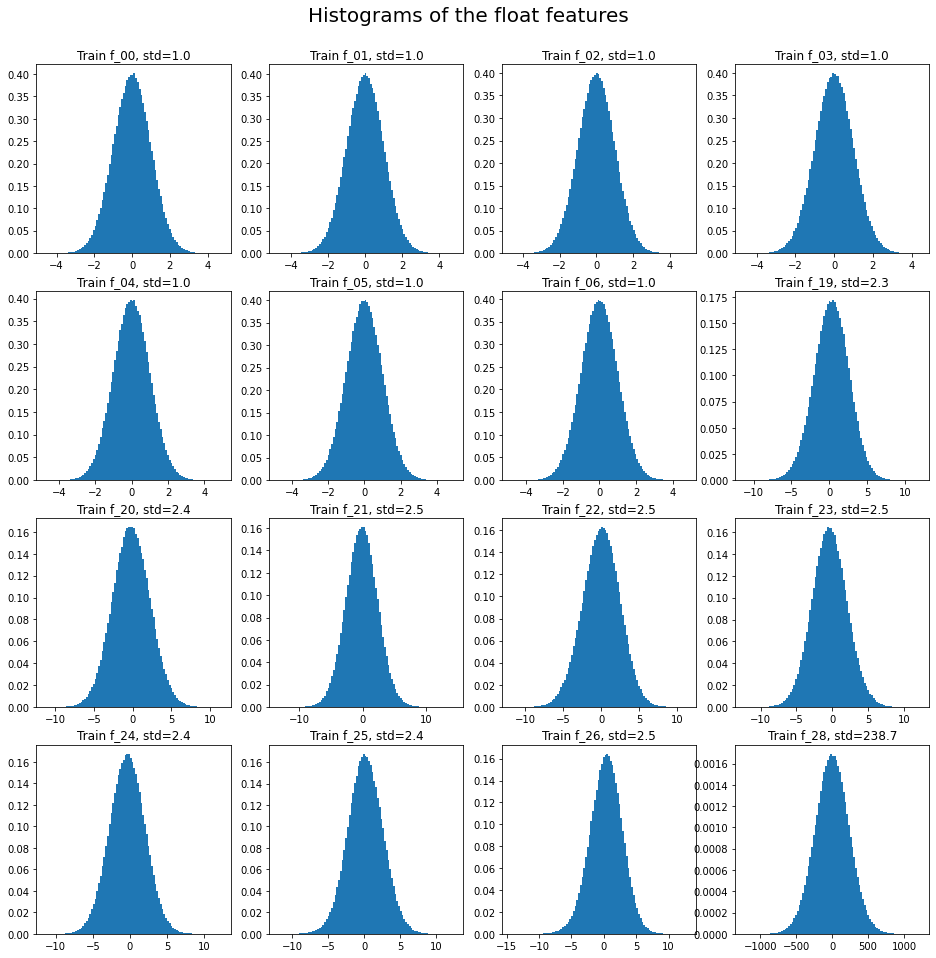

In [45]:
# Check out distribution of features using diagram
# Check float features

fig, axs = plt.subplots(4,4 ,figsize=(16,16))
for f, ax in zip(float_list_train,axs.ravel()):
  ax.hist(train[f], density=True, bins=100)
  ax.set_title(f'Train {f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the float features',y=0.93,fontsize=20)
plt.show()


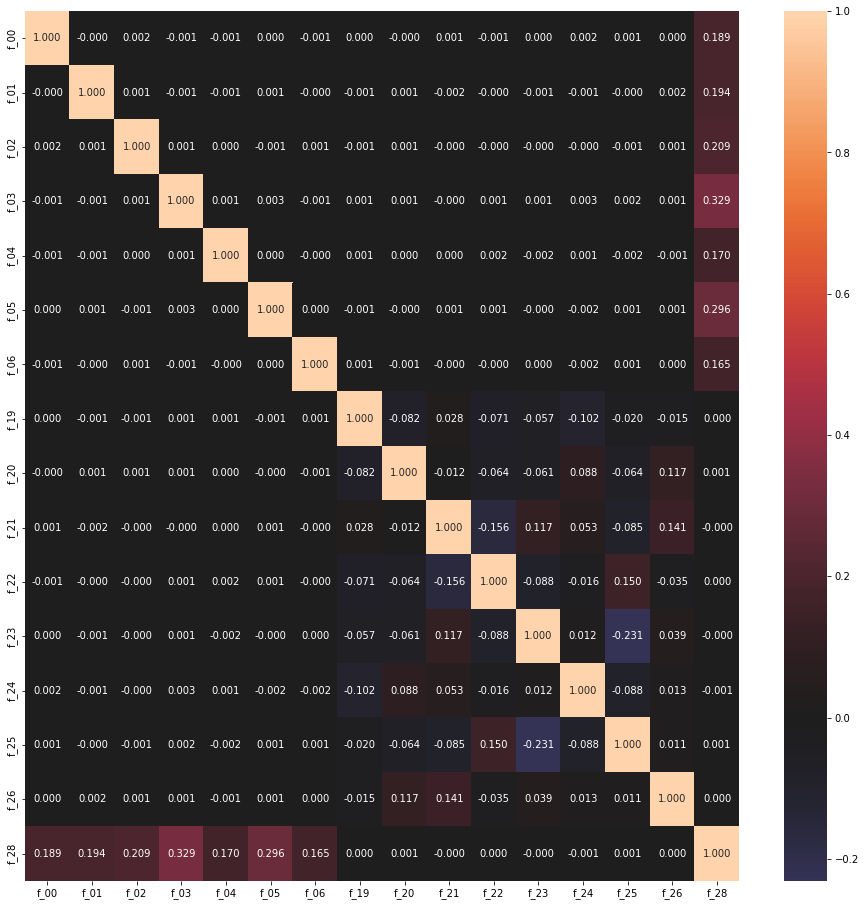

In [47]:
# Correlation matrix of float features
plt.figure(figsize=(16,16))
sns.heatmap(train[float_list_train].corr(),center=0,annot=True,fmt='.3f')

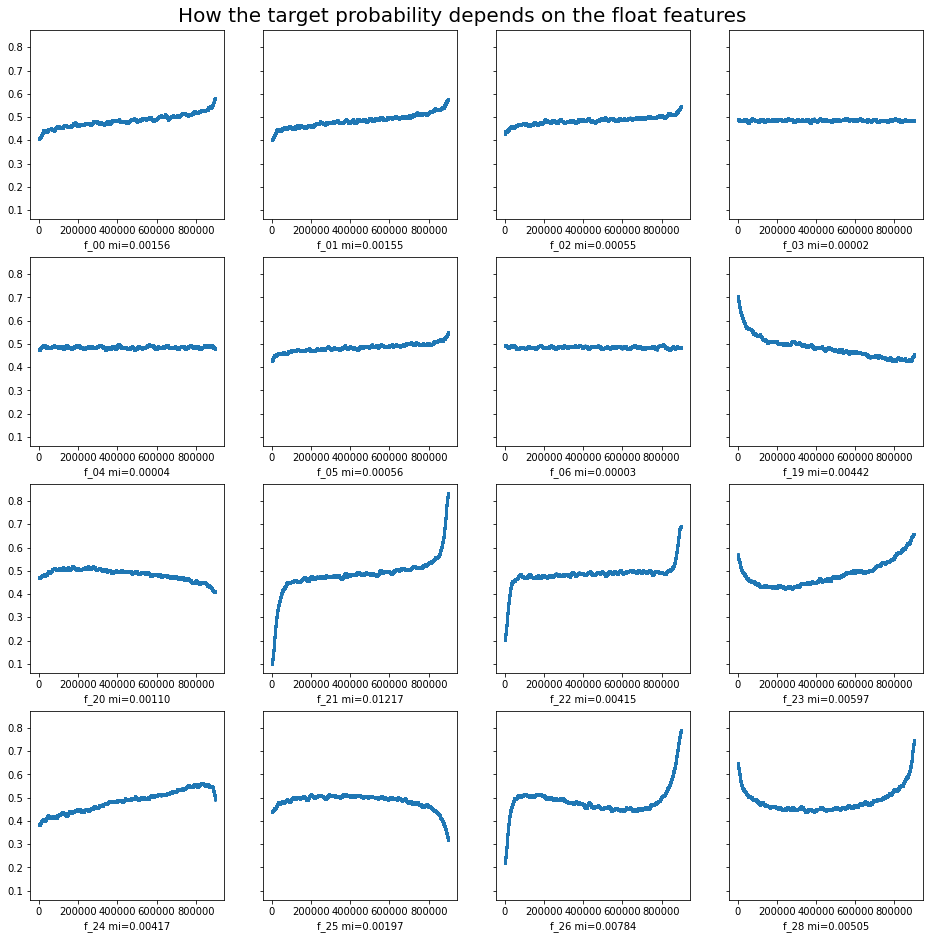

In [48]:
# Plot dependence between every feature and the target
def plot_mutual_info_diagram(df, features, ncols=4, by_quantile=True, mutual_info=True,
                             title='How the target probability depends on single features'):
    def H(p):
        """Entropy of a binary random variable in nat"""
        return -np.log(p) * p - np.log(1-p) * (1-p)
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)
    for f, ax in zip(features, axs.ravel()):
        temp = pd.DataFrame({f: df[f].values,
                             'state': df.target.values})
        temp = temp.sort_values(f)
        temp.reset_index(inplace=True)
        rolling_mean = temp.state.rolling(15000, center=True, min_periods=1).mean()
        if by_quantile:
            ax.scatter(temp.index, rolling_mean, s=2)
        else:
            ax.scatter(temp[f], rolling_mean, s=2)
        if mutual_info and by_quantile:
            ax.set_xlabel(f'{f} mi={H(temp.state.mean()) - H(rolling_mean[~rolling_mean.isna()].values).mean():.5f}')
        else:
            ax.set_xlabel(f'{f}')
    plt.suptitle(title, y=0.90, fontsize=20)
    plt.show()

plot_mutual_info_diagram(train, float_list_train,
                         title='How the target probability depends on the float features')

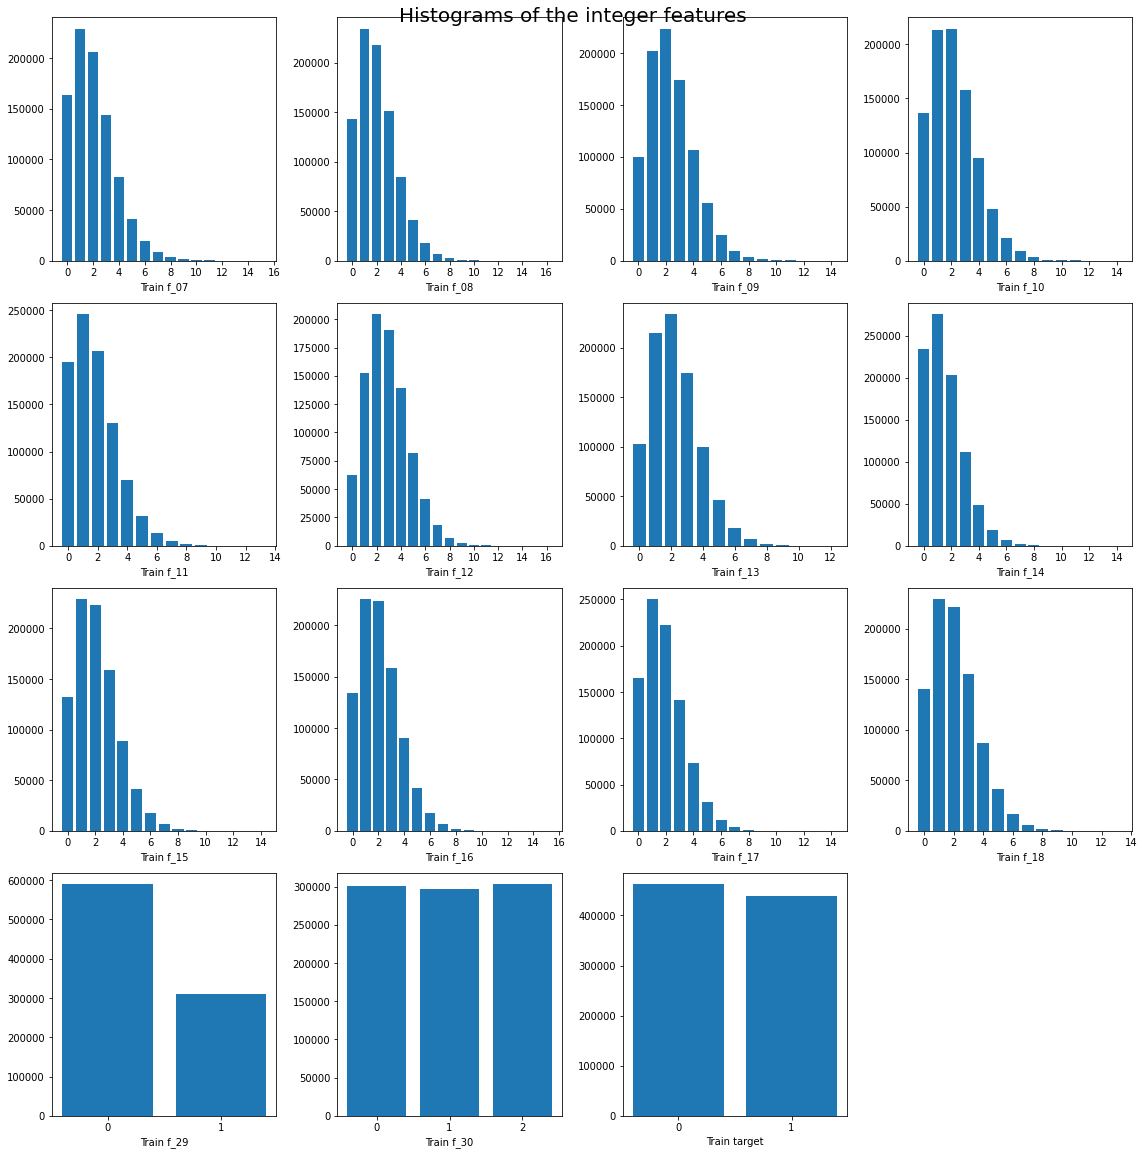

In [49]:
#Check integerfeatures
# Training histograms

from matplotlib.ticker import MaxNLocator

figure = plt.figure(figsize=(16, 16))

for i, f in enumerate(int_list_train):
    plt.subplot(4, 4, i+1)
    ax = plt.gca()
    vc = train[f].value_counts()
    ax.bar(vc.index, vc)
    
    ax.set_xlabel(f'Train {f}')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.suptitle('Histograms of the integer features', y=1.0, fontsize=20)
figure.tight_layout(h_pad=1.0)
plt.show()


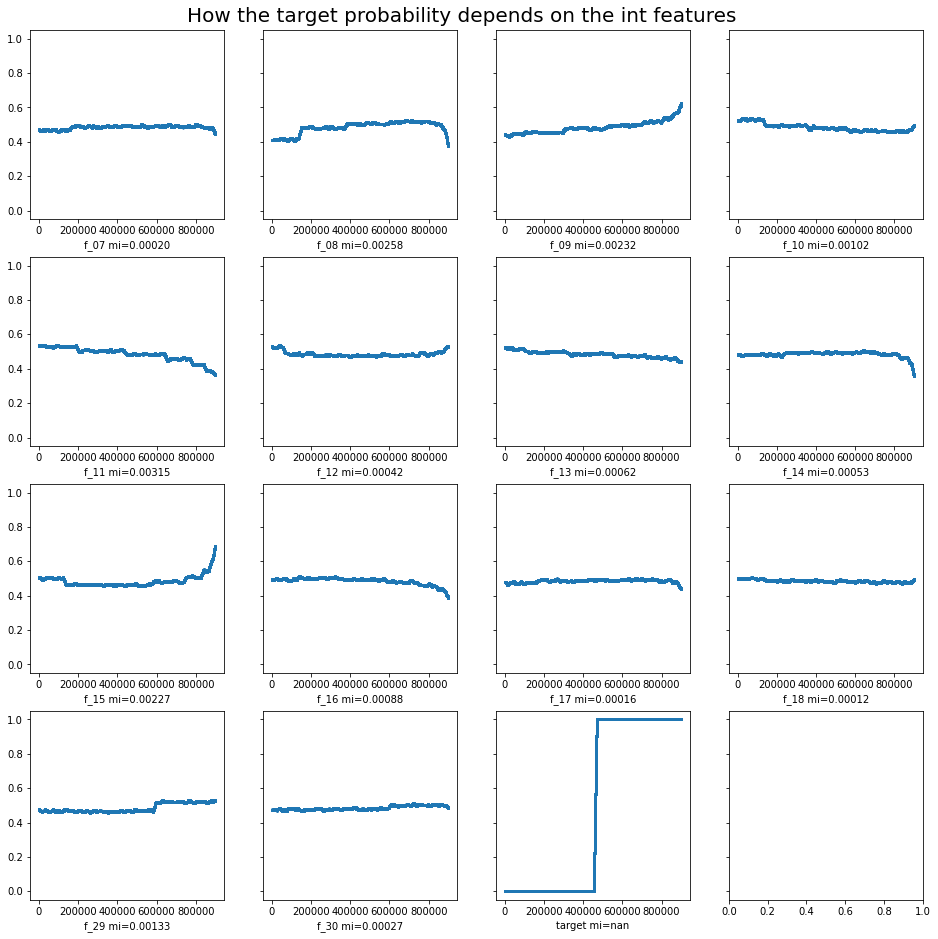

In [50]:
plot_mutual_info_diagram(train, int_list_train,
                         title='How the target probability depends on the int features')

In [51]:
# Check string feature f_27
train['f_27'].value_counts()

BBBBBBCJBC    12
BCBBBBCLBC    12
BBBBBBDPCB    10
BBBBBBDKBC    10
ADBBBACQBC    10
              ..
BFAFAADTCE     1
BBBDAACOAE     1
BBABAACGBB     1
BFAABAGSDB     1
BCAACADSCE     1
Name: f_27, Length: 741354, dtype: int64

In [52]:
pd.concat([train, test]).f_27.value_counts()

BAAACABLBB    15
ACBBAABCBC    15
BAAACABNBC    15
BCBBBBCDCC    14
BBBBBBCJBC    13
              ..
ABBAAAECEB     1
ACBCBAEOAE     1
BBBCBBCACG     1
BBACDAANGA     1
AAAJCBGQBA     1
Name: f_27, Length: 1181880, dtype: int64

In [53]:
# Check distribution of eachletter in string

for i in range(10):
    print(f'Position {i}')
    tg = train.groupby(train.f_27.str.get(i))
    temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
    print(temp)
    print()

Position 0
        size  probability
f_27                     
A     451207         0.54
B     448793         0.44

Position 1
        size  probability
f_27                     
A     144762         0.58
B     245160         0.48
C     225931         0.49
D     149579         0.45
E      78807         0.43
F      35487         0.42
G      13713         0.41
H       4647         0.40
I       1361         0.40
J        410         0.38
K        113         0.39
L         25         0.28
M          3         0.67
N          2         1.00

Position 2
        size  probability
f_27                     
A     297840         0.53
B     602160         0.46

Position 3
        size  probability
f_27                     
A     160839         0.57
B     237218         0.48
C     210015         0.48
D     143633         0.45
E      81662         0.43
F      39504         0.44
G      17121         0.45
H       6473         0.47
I       2379         0.48
J        772         0.51
K        254     

In [ ]:
# Count unique characters in a string ans use that as a new feature

In [54]:
unique_characters = train.f_27.apply(lambda s: len(set(s))).rename('unique_characters')
tg = train.groupby(unique_characters)
temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
print(temp)


                     size  probability
unique_characters                     
1                       1         0.00
2                    1092         0.09
3                   32164         0.09
4                  211165         0.48
5                  399974         0.49
6                  220715         0.48
7                   33698         0.91
8                    1185         0.91
9                       6         1.00


In [55]:
# Separate string in to 10 unique features
for df in [train, test]:
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))

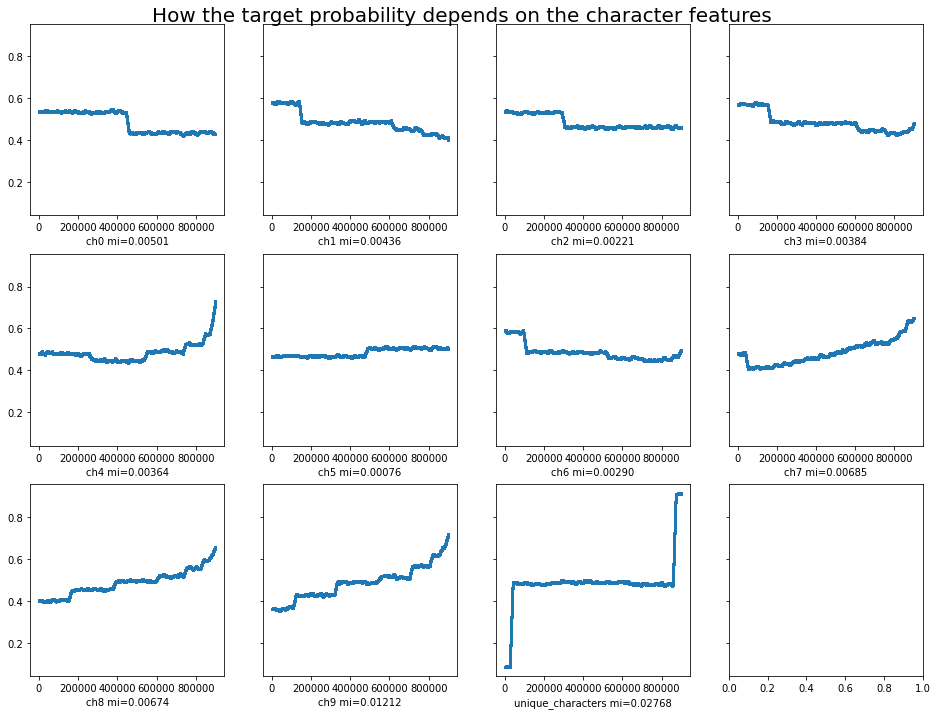

In [56]:
plot_mutual_info_diagram(train, 
                         [f for f in train.columns if f.startswith('ch')] + ['unique_characters'],
                         title='How the target probability depends on the character features')

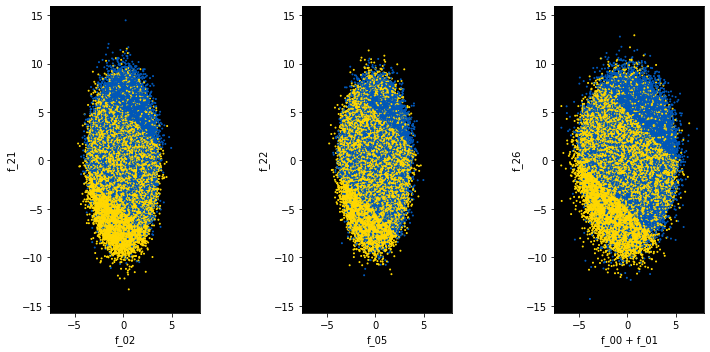

In [57]:
from matplotlib.colors import ListedColormap

plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])
# target == 0 → yellow; target == 1 → blue

ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.savefig('three-projections.png')
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue

In [58]:
#create new features using features from above diagram.

In [59]:
for df in [train, test]:
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)#

In [60]:
train.head()

f_00      f_01      f_02      f_03      f_04      f_05      f_06  \
id                                                                         
0  -1.373246  0.238887 -0.243376  0.567405 -0.647715  0.839326  0.113133   
1   1.697021 -1.710322 -2.230332 -0.545661  1.113173 -1.552175  0.447825   
2   1.681726  0.616746 -1.027689  0.810492 -0.609086  0.113965 -0.708660   
3  -0.118172 -0.587835 -0.804638  2.086822  0.371005 -0.128831 -0.282575   
4   1.148481 -0.176567 -0.664871 -1.101343  0.467875  0.500117  0.407515   

    f_07  f_08  f_09  ...  ch4  ch5  ch6  ch7  ch8  ch9  unique_characters  \
id                    ...                                                    
0      1     5     1  ...    3    0    3    1    0    1                  3   
1      1     3     4  ...    2    0    3    2    4    1                  5   
2      1     0     2  ...    0    1    2   10    0    3                  6   
3      3     2     1  ...    0    0    2    1    2    1                  4   
4      3     3     0  ...    1    1    2    7    5    4                  6   

    i_02_21  i_05_22  i_00_01_26  
id                                
0         0        0           0  
1         0        0           0  
2         0        0           0  
3         0        0           0  
4         0        0           1  

[5 rows x 46 columns]

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700000 entries, 900000 to 1599999
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   f_00               700000 non-null  float32
 1   f_01               700000 non-null  float32
 2   f_02               700000 non-null  float32
 3   f_03               700000 non-null  float32
 4   f_04               700000 non-null  float32
 5   f_05               700000 non-null  float32
 6   f_06               700000 non-null  float32
 7   f_07               700000 non-null  int16  
 8   f_08               700000 non-null  int16  
 9   f_09               700000 non-null  int16  
 10  f_10               700000 non-null  int16  
 11  f_11               700000 non-null  int16  
 12  f_12               700000 non-null  int16  
 13  f_13               700000 non-null  int16  
 14  f_14               700000 non-null  int16  
 15  f_15               700000 non-null  int16  
 

In [70]:

# Gradient boosting algorithm
scaler = StandardScaler()
y=train['target']
x=train.drop(['target', 'f_27'], axis=1)
#test=test.drop([ 'f_27'], axis=1)
x=pd.DataFrame(scaler.fit_transform(x),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(test))

y_valid, gbm_val_preds, gbm_test_preds=[],[],[]
cal_true, cal_pred=[],[]
feat_importance=pd.DataFrame(index=x.columns)
k_fold=KFold(n_splits=5,shuffle=True, random_state=21)
for fold, (train_idx,val_idx) in enumerate(k_fold.split(x,y)):

  print("\nFold {}".format(fold+1))
  x_train, y_train =x.iloc[train_idx,:],y[train_idx]
  x_val, y_val=x.iloc[val_idx,:],y[val_idx]
  print("Train shape : {}, {}, Valid shape : {},{}".format(x_train.shape,y_train.shape,x_val.shape,y_val.shape))

  params={'boosting_type':'gbdt',
          'n_estimators': 250,
          'num_leaves': 50,
          'learning_rate':0.1,
          'colsample_bytree':0.9,
          'subsample':0.8,
          'reg_alphs':0.1,
          'objective':'binary',
          'metric':'auc',
          'random_state':21}
  gbm= LGBMClassifier(**params).fit(x_train, y_train, eval_set=[(x_train, y_train),(x_val,y_val)],
                                    verbose=100,
                                    eval_metric=['binary_logloss','auc'])
  gbm_prob =gbm.predict_proba(x_val)[:,1]
  y_valid.append(y_val)
  gbm_val_preds.append(gbm_prob)
  gbm_test_preds.append(gbm.predict_proba(x_test)[:,1])
  feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_

  calibrated_gbm=CalibratedClassifierCV(base_estimator=gbm, cv='prefit')
  cal_fit=calibrated_gbm.fit(x_train,y_train)
  cal_probs =calibrated_gbm.predict_proba(x_val)[:,1]
  prob_true,prob_pred =calibration_curve(y_val, cal_probs,n_bins=10)
  cal_true.append(prob_true)
  cal_pred.append(prob_pred)

  auc_score=roc_auc_score(y_val,gbm_prob)
  print("Validation AUC ={:0.4f}".format(auc_score))
  del x_train, y_train, x_val, y_val
  gc.collect()




Fold 1
Train shape : (720000, 44), (720000,), Valid shape : (180000, 44),(180000,)
[100]	training's binary_logloss: 0.197116	training's auc: 0.987334	valid_1's binary_logloss: 0.199568	valid_1's auc: 0.986556
[200]	training's binary_logloss: 0.136129	training's auc: 0.99266	valid_1's binary_logloss: 0.140323	valid_1's auc: 0.991757
Validation AUC =0.9928

Fold 2
Train shape : (720000, 44), (720000,), Valid shape : (180000, 44),(180000,)
[100]	training's binary_logloss: 0.198605	training's auc: 0.987044	valid_1's binary_logloss: 0.201415	valid_1's auc: 0.986101
[200]	training's binary_logloss: 0.135612	training's auc: 0.992752	valid_1's binary_logloss: 0.140303	valid_1's auc: 0.991741
Validation AUC =0.9927

Fold 3
Train shape : (720000, 44), (720000,), Valid shape : (180000, 44),(180000,)
[100]	training's binary_logloss: 0.197903	training's auc: 0.987244	valid_1's binary_logloss: 0.200913	valid_1's auc: 0.986378
[200]	training's binary_logloss: 0.136718	training's auc: 0.992533	valid_

In [74]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
colors=px.colors.qualitative.Prism
color=px.colors.qualitative.Plotly
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
def plot_roc_calibration(y_val, y_prob, mpv_cal, fop_cal):
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Random Chance',mode='lines',
                             line=dict(color="Black", width=1, dash="dot")))
    for i in range(len(y_val)):
        y=y_val[i]
        prob=y_prob[i]
        fpr, tpr, thresh = roc_curve(y, prob)
        roc_auc = auc(fpr,tpr)
        fig.add_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=colors[::-1][i+6], width=3), 
                                 hovertemplate = 'True positive rate = %{y:.3f}, False positive rate = %{x:.3f}',
                                 name='Fold {} AUC = {:.4f}'.format(i+1,roc_auc)))
    fig.update_layout(template=temp, title="Cross-Validation ROC Curves", 
                      hovermode="x unified", width=600,height=500,
                      xaxis_title='False Positive Rate (1 - Specificity)',
                      yaxis_title='True Positive Rate (Sensitivity)',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,1,11), y=np.linspace(0,1,11), 
                             name='Perfectly Calibrated',mode='lines',
                             line=dict(color="Black", width=1, dash="dot"),legendgroup=2))
    for i in range(len(mpv_cal)):
        mpv=mpv_cal[i]
        fop=fop_cal[i]
        fig.add_trace(go.Scatter(x=mpv, y=fop, line=dict(color=colors[::-1][i+6], width=3), 
                                 hovertemplate = 'Proportion of Positives = %{y:.3f}, Mean Predicted Probability = %{x:.3f}',
                                 name='Fold {}'.format(i+1),legendgroup=2))
    fig.update_layout(template=temp, title="Probability Calibration Curves", 
                      hovermode="x unified", width=600,height=500,
                      xaxis_title='Mean Predicted Probability',
                      yaxis_title='Proportion of Positives',
                      legend=dict(orientation='v', y=.07, x=1, xanchor="right",
                                  bordercolor="black", borderwidth=.5))
    fig.show()
    
def plot_target_predictions(df):
    plot_df=pd.DataFrame.from_dict({'1':(len(df[df.target>0.5])/len(df.target))*100, 
                                    '0':(len(df[df.target<=0.5])/len(df.target))*100}, 
                                   orient='index', columns=['pct'])
    text=['State {}'.format(i) for i in plot_df.index]
    color,pal=['#38A6A5','#E1B580'],['#88CAC9','#EDD3B3']
    if text[0]=='State 0':
        color,pal=color,pal
    else:
        color,pal=color[::-1],pal[::-1]
    fig=go.Figure()
    fig.add_trace(go.Pie(labels=plot_df.index, values=plot_df.pct, hole=.5, 
                         text=text, sort=False, showlegend=False,
                         marker=dict(colors=pal,line=dict(color=color,width=2)),
                         hovertemplate = "State %{label}: %{value:.2f}%<extra></extra>"))
    fig.update_layout(template=temp, title='Predicted Target Distribution', width=700,
                      uniformtext_minsize=15, uniformtext_mode='hide')
    fig.show()
    
plot_roc_calibration(y_valid, gbm_val_preds, cal_true, cal_pred)

In [77]:
# Check Feature importances
feat_importance['avg']=feat_importance.mean(axis=1)
feat_impotance=feat_importance.sort_values(by='avg',ascending=True)
pal=sns.color_palette("YlGnBu",52).as_hex()
fig=go.Figure()
for i in range(len(feat_importance.index)):
  fig.add_shape(dict(type='line',y0=i, y1=i,x0=0,x1=feat_importance['avg'][i],line_color=pal[::-1][i],opacity=0.8,line_width=4))
  fig.add_trace(go.Scatter(x=feat_importance['avg'],y=feat_importance.index,mode='markers',marker_color=pal[::-1],marker_size=8,
                           hovertemplate='%{y} Importance = %{x: .0f}<extra></extra>'))
  fig.update_layout(template=temp,title='Feature Importance',
                    xaxis=dict(title='Average Importance, zeroline=False'),
                    yaxis_showgrid=False,height=900,width=800)
  fig.show()

In [82]:
sub_gbm=sub.copy()
sub_gbm['target']=np.mean(gbm_test_preds,axis=0)
sub_gbm.to_csv("sub_gbm.csv",index=False)
plot_target_predictions(sub_gbm)